In [4]:
%matplotlib inline
import numpy as np
import subprocess
import matplotlib.pyplot as plt

In [5]:
def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    """

    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found

In [6]:
def get_SNR(file):
    with open(file, "rt")as f:
        a = f.readlines()
    lst = []
    for x in a:
        if "Value:" in x:
            lst.append(float(x.split("Value: ")[1]))
        #print(x.split("bla"))
    lst = lst[len(lst)//2 : ]
    return (np.array(lst).mean(), np.array(lst).std())

In [56]:
def noDiffEnc_Corrector(file, invert = False):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    
    tx = np.array([  0,   0, 220,  43, 133,  48, 210, 169, 246, 50, 213, 201,  36,
           235,  35, 177, 159, 191,  21,  67,  77,  94,  82, 239, 196, 230,
            37,  67,  51, 236], dtype = np.uint8)
    
    if invert:
        tx = np.invert(tx)
    
    pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(tx)))
    rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))
    
    new_arr = []
    tx_inverted = np.invert(tx)
    rcv_splitted = np.split(rcv, len(rcv)/len(tx))
    for x in rcv_splitted:
        comp1 = np.mean(np.equal(np.unpackbits(tx), np.unpackbits(x)))
        comp2 = np.mean(np.equal(np.unpackbits(tx_inverted), np.unpackbits(x)))
        if comp2 > comp1:
            new_arr.append(np.invert(x))
        else:
            new_arr.append(x)
    final_array = np.array(new_arr, dtype = np.uint8).ravel()
    
    if invert:
        final_array = np.invert(final_array)
        
    print(final_array[:30])

    with open("output2.data", "wb") as f:
        f.write(final_array)
    return

In [50]:
with open("output.data", "rb")as f:
    _ = f.read()
    
rcv = np.frombuffer(_, dtype = np.uint8)

tx = np.array([  0,   0, 220,  43, 133,  48, 210, 169, 246, 50, 213, 201,  36,
       235,  35, 177, 159, 191,  21,  67,  77,  94,  82, 239, 196, 230,
        37,  67,  51, 236], dtype = np.uint8)

pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(tx)))
rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))

In [51]:
rcv

array([ 78,  96,  64, ..., 219,  20, 220], dtype=uint8)

In [52]:
pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(np.invert(tx))))
rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))
rcv

array([255, 255,  35, ..., 188, 204,  19], dtype=uint8)

In [ ]:
new_arr = []
tx_inverted = np.invert(tx)
rcv_splitted = np.split(rcv, len(rcv)/len(tx))
for x in rcv_splitted:
    comp1 = np.mean(np.equal(np.unpackbits(tx), np.unpackbits(x)))
    comp2 = np.mean(np.equal(np.unpackbits(tx_inverted), np.unpackbits(x)))
    if comp2 > comp1:
        new_arr.append(np.invert(x))
    else:
        new_arr.append(x)
final_array = np.array(new_arr, dtype = np.uint8).ravel()

In [43]:
def step1(file, invert = False):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    
    match = np.array([  0,   0, 220,  43, 133,  48, 210, 169, 246, 50, 213, 201,  36,
           235,  35, 177, 159, 191,  21,  67,  77,  94,  82, 239, 196, 230,
            37,  67,  51, 236], dtype = np.uint8)
    
    if invert:
        match = np.invert(match)
        
    match_extended = np.tile(match, int(rcv.shape[0]/len(match)))
    idx = np.argmax([np.mean(np.equal(np.packbits(np.roll(np.unpackbits(rcv), i)), match_extended)) for i in range(30 * 8)])
    to_write = np.packbits(np.roll(np.unpackbits(rcv), idx))
    to_write = np.invert(to_write)
    
    with open("output2.data", "wb") as f:
        f.write(to_write)
    return invert

In [44]:
def step2():
    process=subprocess.Popen(["python2", "BCH_Recoder.py"],
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE)


    #time.sleep(10)

    # while os.stat("output.data").st_size < os.stat("orig_pinguim.bmp").st_size * 2:
    #     pass

    inputdata= b" "
    stdoutdata,stderrdata=process.communicate(input=inputdata)
    
    return

In [45]:
def step3(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    final = np.frombuffer(_, dtype = np.uint8)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    match_extended_final = np.tile(tx, int(final.shape[0]/len(tx)))
    
    return (1 - np.mean(np.equal(np.unpackbits(final), np.unpackbits(match_extended_final))))

In [62]:
%%time
noDiffEnc_Corrector("output.data", invert = True)

[  0   0 220  43 133  48 210 169 246  50 213 201  36 235  35 177 159 191
  21  67  77  94  82 239 196 230  37  67  51 236]
CPU times: user 18.9 s, sys: 20 ms, total: 18.9 s
Wall time: 18.9 s


In [63]:
# %%time
# step1("output.data", invert = True)

In [64]:
%%time
step2()

CPU times: user 1.73 ms, sys: 3.99 ms, total: 5.72 ms
Wall time: 11.2 s


In [65]:
%%time
step3("output3.data")

CPU times: user 27.9 ms, sys: 4 ms, total: 31.9 ms
Wall time: 31.8 ms


0.0003539285714285745

In [66]:
get_SNR("output.txt"), step3("output3.data")

((4.0054007462686565, 0.3420819900729632), 0.0003539285714285745)

In [ ]:
with open("output.data", "rb")as f:
        _ = f.read()
    
rcv = np.frombuffer(_, dtype = np.uint8)

match = np.array([  0,   0, 220,  43, 133,  48, 210, 169, 246, 50, 213, 201,  36,
       235,  35, 177, 159, 191,  21,  67,  77,  94,  82, 239, 196, 230,
        37,  67,  51, 236], dtype = np.uint8)

if True:
    match = np.invert(match)

match_extended = np.tile(match, int(rcv.shape[0]/len(match)))
idx = np.argmax([np.mean(np.equal(np.packbits(np.roll(np.unpackbits(rcv), i)), match_extended)) for i in range(30 * 8)])
to_write = np.packbits(np.roll(np.unpackbits(rcv), idx))

In [ ]:
to_write[:100]

## <font color = red> Quanto mais baixo o SNR, maior a chance de ocorrer problemas na recepção, mais chance do resultado obtido ser ruim
    
# <font color = blue> Resultados obtidos simulados
  <font color = blue> SNR Média, SNR STD, BER


In [67]:
a = """
((4.0054007462686565, 0.3420819900729632), 0.0003539285714285745)
"""

In [68]:
snr_avgs = []
snr_stds = []
bers = []

for line in a.splitlines():
    aux = line.replace("(", "").replace(")", "").split(",")
    if aux != [""]:
        snr_avgs.append(float(aux[0]))
        snr_stds.append(float(aux[1]))
        bers.append(float(aux[2]))

In [69]:
import math

In [70]:
10*math.log10(15/7)

3.3099321904142442

In [71]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)

In [72]:
EbN0_range = np.load("Numpy vector refs/EbN0List.npy")

In [73]:
theory_de_bpsk = np.load("Numpy vector refs/theory_de-bpsk.npy")

In [74]:
simu_de_bpsk = np.load("Numpy vector refs/simu_de-bpsk.npy")

In [75]:
simu_de_bpsk_bch_15_7 = np.load("Numpy vector refs/simu_de-bpsk-bch-15-7-2.npy")

In [76]:
np.array(snr_avgs) + 10*math.log10(15/7)

array([7.31533294])

In [77]:
EbN0_range

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

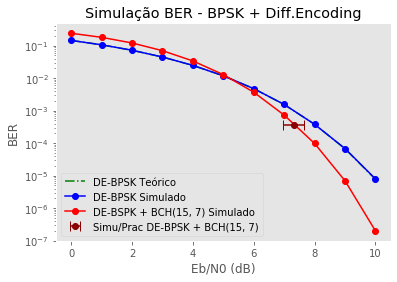

In [78]:
plt.style.use('ggplot')
plt.semilogy(EbN0_range, theory_de_bpsk, "g-.", label = "DE-BPSK Teórico")
plt.semilogy(EbN0_range, simu_de_bpsk, "b-o", label = "DE-BPSK Simulado")
plt.semilogy(EbN0_range, simu_de_bpsk_bch_15_7, "r-o", label = "DE-BSPK + BCH(15, 7) Simulado")
# plt.semilogy(np.array(snr_avgs) + 10 * math.log10(15/7), bers, "*", color = "darkred", label = "Simu/Prac DE-BPSK")
plt.errorbar(np.array(snr_avgs) + 10 * math.log10(15/7), bers, xerr = np.array(snr_stds), fmt = "o", color = "darkred", capsize = 5, label = "Simu/Prac DE-BPSK + BCH(15, 7)")

plt.legend()
plt.grid()

plt.title('Simulação BER - BPSK + Diff.Encoding')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.savefig("Curva.png")